# PyTorch for Neural Networks

### 20th October 2023 by Mingfei Sun

In this Notebook, we look at the torch library in Python that allows automatic differentiation. PyTorch will be used to implement different neural network models later on.

### Tensors
A tensor generalises the concept of vectors and matrices to an arbitrary number of dimensions. Another name for the same concept is multidimensional arrays. The dimensionality of a tensor is the number of indexes used to refer to scalar values within the tensor. The cell below shows an example initialising a Tensor uniformly for 1D, 2D and 3D:

In [ ]:
# We first import the torch library that comes with the Anaconda distribution
import torch
# Tensor 1D presents 1 index
y = torch.rand([2])
print('Tensor 1D presents one index','with shape', y.shape,':\n',y) #get specific size with .shape
# Tensor 2D presents 2 indexes
y = torch.rand([2,3])
print('\nTensor 2D presents two indexes','with shape',y.shape,':\n',y)
#Tensor 3D presents 3 indexes
y = torch.rand([5,2,3])
print('\nTensor 3D presents three indexes','with shape',y.shape,':\n',y)

In [ ]:
# Create a tensor with specific values
x = torch.tensor([4.0,5.0],dtype=torch.float32)
y = torch.tensor([2.0,3.0],dtype=torch.float32)

# Tensor multiplication (point-wise multiplication)
print(x*y)

### Initialise a tensor with torch.zeros or torch.ones

In [ ]:
x_zeros = torch.zeros([3,4])
print('x_zeros:',x_zeros,'with shape',x_zeros.shape,'\n')
x_ones = torch.ones([2,6])
print('x_ones:',x_ones,'with shape',x_ones.shape)

### Reshape a tensor using .view

In [ ]:
y = torch.ones([3,2])
y_reshaped = y.view(6,1)  # in contrast to the common numpy library, we use .view instead of .reshape
print(y_reshaped)

### Numpy interoperability

PyTorch tensors can be converted efficiently to NumPy arrays and vice versa. By doing so, you can leverage the huge swath of functionality in the wider Python ecosystem that has built up around the NumPy array type.

In [ ]:
# Tensor_torch to tensor Numpy
Tensor_torch = torch.ones(3,4)
Tensor_numpy = Tensor_torch.numpy() #Returns a NumPy multidim. array of the right size, shape and numerical type.
print('Array in numpy form with shape', Tensor_numpy.shape,':\n',Tensor_numpy)

# Tensor Numpy to Tensor_torch
import numpy as np
Tensor_np = np.random.randn(5,8)
Tensor_numpy_to_torch = torch.from_numpy(Tensor_np)
print('\nArray from Numpy to Torch with shape', Tensor_numpy_to_torch.shape,':\n',Tensor_numpy_to_torch)

## Automatic Differentiation

PyTorch allows to automatically obtain the gradients of a tensor with respect to a defined function. When creating the tensor, we have to indicate that it requires the gradient computation using the flag `requires_grad`  

In [ ]:
x = torch.rand(3,requires_grad=True)
print(x)

Notice that now the Tensor shows the flag `requires_grad` as True. We can also activate such a flag in a Tensor already created as follows:

In [ ]:
x = torch.tensor([1.0,2.0,3.0])
print(x)
x.requires_grad_(True)
print(x)

Let us define a function $y=x^2+5$. The function $y$ will not only carry the result of evaluating $x$, but also the gradient function $\frac{\partial y}{\partial x}$ called `grad_fn` in the new tensor $y$

In [ ]:
x = torch.tensor([2.0])
x.requires_grad_(True)  # indicate we will need the gradients with respecto to this variable
y = x**2 + 5
print(y)

To evaluate the partial derivative $\frac{\partial y}{\partial x}$, we use the `.backward()` function and the result of the gradient evaluation is stored in `x.grad`

In [ ]:
y.backward()  #dy/dx
print('PyTorch gradient:', x.grad)

# Let us compare with the analytical gradient of y = x**2+5
with torch.no_grad():    # this is to only use the tensor value without its gradient information
    dy_dx = 2*x  # analytical gradient
print('Analytical gradient:', dy_dx)

If we evaluate a vector $\mathbf{w}=[w_1, \ldots, w_D]^{\top}$, to compute another vector $\mathbf{g}=[g_1, \ldots, g_D]^{\top}$ with elements $g_i=w_i^2+5$, then we obtain a vector $\mathbf{g}$ that contains each evaluation of the function. If we want to obtain the gradient w.r.t $\mathbf{w}$ by using "g.backward()", we have to bypass a vector of size equal to w.shape to the function, i.e., "g.backward(vect)".

In [ ]:
w = torch.tensor([1.0,2.0,3.0])
w.requires_grad_(True)

g = w**2+5
# Below, the values [1.0,1.0,1.0] are multiplied by the gradient g.backward(vect)
# of course using the ones does not modify the value of the gradient
vect = torch.tensor([1.0,1.0,1.0],dtype=torch.float32)
g.backward(vect)
print(w.grad)

On the other hand, when accessing the gradients in a for loop, PyTorch acummulates the gradients at each
iteration. In order to avoid this behaviour, we have to use the function .grad.zero_() also at each iteration. See in the example below what happens when commenting and uncommenting the line "w.grad.zero_()":

In [ ]:
#Pytorch uses a cumulative process for the gradients
w = torch.tensor([1.0,2.0,3.0])
w.requires_grad_(True)

for i in range(3):
    g = w**2+5
    g.backward(torch.ones_like(w))
    print(w.grad)
    w.grad.zero_()    #this line avoids the acummulation of the gradients uncomment it to see its effect

###  Question 1

Verify that the gradients provided by PyTorch coincide with the analytical gradients of the function $f = \exp \big(-x^2-2x- \sin (x) \big)$ w.r.t $x$.

In [ ]:
# Provide your answer here

## Linear Regression Basic Example

We now provide a very simple example of linear regression with one input dimension, $y=wx+b$, and illustrate how we use PyTorch to optimise the parameters of the model

In [14]:
Ndata = 100
x = torch.rand(Ndata)
true_w = 1.5
true_bias = 1.0
# We generate the dataset from the actual model but adding some noise
y = true_w*x + true_bias + 0.05*torch.randn(Ndata)
# We make sure to set the requires_grad flag to True for both paratemers
w = torch.tensor(0.0,dtype=torch.float32,requires_grad=True)
bias = torch.tensor(0.0,dtype=torch.float32,requires_grad=True)

We now define two useful functions, the prediction function and the objective function

In [15]:
def model_prediction(x,w,bias):
    return w*x + bias

def loss_function(y,y_pred):
    return ((y_pred-y)**2).mean()  # Mean Squared Error (MSE)

And we use gradient descent to estimate the parameters of the model

\begin{align*}
    w_{k+1} = w_k - \eta \frac{dE}{dw}\\
    b_{k+1} = b_k - \eta \frac{dE}{db}\\
\end{align*}

We know that there is a closed form solution for $w$ and $b$ through the normal equation. The example is for illustrative purposes.

In [ ]:
Max_Niter = 500
step_size = 0.1
for Niter in range(Max_Niter):
    # Evaluate the prediction and the loss
    y_approx = model_prediction(x,w,bias)
    my_loss = loss_function(y,y_approx)

    # The function .backward() has to be called in order to load the grads in w.grad
    # Notice that here it is not necessary to bypass a vector since loss_function is a scalar function
    my_loss.backward()

    with torch.no_grad():        # this line avoids the gradient update while allowing to change the value of w
        w -= step_size * w.grad    # it is necessary to avoid the grad update while modifying the variable
        bias -= step_size * bias.grad

    # Make the zero gradient to avoid acummulation
    w.grad.zero_()
    bias.grad.zero_()

    # We print the loss, and the parameters values every 50 iterations
    if Niter%50==0:
        print(f'Iteration = {Niter+1}, Loss = {my_loss:.8f}, w = {w:.3f}, bias = {bias:.3f}')

print(f'Iteration = {Niter+1}, Loss = {my_loss:.8f}, w = {w:.3f}, bias = {bias:.3f}')

We finally plot the result

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x,y,'x')
xtest = torch.linspace(0,1,10)
with torch.no_grad():
    y_pred = model_prediction(xtest,w,bias)
plt.plot(xtest,y_pred)

### Loading a .csv dataset

We can take advantage of the interoperability between Numpy and PyTorch by loading a .csv data as a numpy array and transforming it to a Torch Tensor using `torch.from_numpy(dataset_np)`.

In [18]:
# This cell is simply to download the winequality-red.csv dataset from its root url
import urllib.request
urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', './winequality-red.csv')

('./winequality-red.csv', <http.client.HTTPMessage at 0x7c8f7a04d5a0>)

In [ ]:
import numpy as np
#In the line below we avoid the first row (skiprows=1) of .csv file that contains names
#the delimeter of data for this dataset is ";"
wine_np = np.loadtxt("./winequality-red.csv",dtype=np.float32,delimiter=";",skiprows=1)
wine_torch = torch.from_numpy(wine_np)  #We take advantage of the interoperability with numpy
wine_torch

# Pytorch for MLPs
We will now use the pytorch library to train the MLPs. We will use a dataset of digits (MNIST).

## Import libraries and load the dataset
If you are using your own computer, you will need to install Pytorch. Setup guidance is here: https://pytorch.org/get-started/locally/)

In [ ]:
# import pytorch library (load the neural network module as nn, for convenience to save us writing torch.nn every time
import torch
import torch.nn as nn

# import the digits dataset
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
digits = datasets.load_digits()

# get one image
image1 = digits.images[1]
plt.imshow(image1, cmap='Greys')

As we discovered in the previous notebook, pytorch uses tensors as its base unit. So, we will first convert the digits dataset into tensors.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

X_scaled = preprocessing.scale(digits.data)

X_scaled_t = torch.from_numpy(X_scaled)
#X_scaled_t = torch.transpose(X_scaled_t,0,1)
y_t = torch.from_numpy(digits.target)

In the previous part, we explicitly wrote a function called *model_prediction* that described a linear regression model. We apply the same process here, but the model is a little more complex, so we use some of the inbuilt functions within Pytorch. The following code sets up a 1 hidden layer neural network with 20 neurons.

(You may have noticed that we have set up a class, rather than a function (def) here. Broadly, a class is an object that can have many functions applied to it. The nature of an Object is beyond the scope of this course, and if you are interested you should investigate material on object oriented programming).

In [26]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.fc1 = torch.nn.Linear(input_size,20)
        self.fc2 = torch.nn.Linear(20,10)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        output = self.fc2(x)

        return output    # return output of network

Rather that explicitly writing out a loss function, we will use pytorch's inbuilt CrossEntropy loss.

In [27]:
loss_func = nn.CrossEntropyLoss()

We now create a training function - if you compare this to the previous part, you should see that it follows the same basic structure as the linear regression example.

The only exception is that we set the neural network into *train* mode using mlp.train. This is because some more advanced modifications to a neural network (e.g. batch normalisation) perform differently during training and running.

In [28]:
def train(num_epochs, network, X_train, y_train):

    # this sets the model mode - (i.e. layers like dropout, batchnorm etc behave differently during training compared to testing)
    # note that this function was not defined explicitly in CNN, but because CNN is a type of nn.Module, it inherits some functions
    # from the more general nn class.
    network.train()
    for epoch in range(num_epochs):
        output = network(X_train) # this is the model prediction
        loss = loss_func(output, y_train) # evaluate the loss (error)

        # clear gradients for this training step
        optimizer.zero_grad()

        # backpropagation, compute gradients
        loss.backward()
        # apply gradients
        optimizer.step()

        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

    # print the predicted (and true) labels after training. Note that raw output of the neural network is a score for each class, so we use argmax
    # to return the class with the highest score
    print(torch.argmax(output,1))
    print(y_train)

In [ ]:
input_size = X_scaled_t.size(1) # input size is the same size as a digits image (8x8)
mlp = MLP(input_size) # set up an instance of the MLP object
mlp = mlp.double()

# use the adam optimiser to do the updates - this is a modern update to classic stochastic gradient descent
from torch import optim
optimizer = optim.Adam(mlp.parameters(), lr = 0.005)

# call the training function and run over 1000 epochs
num_epochs = 50
train(num_epochs, mlp, X_scaled_t, y_t.long())

## Questions
**Q1** Has the model finished training? (How can you tell whether it has or not?)

**Q2** Modify the *train* function above to dynamically set the number of training epochs, depending on the change in loss between iterations

**Q3** The size (number of neurons) of the hidden layer is 20. Try changing this - how does this affect the loss?

**Q4** Try adding an additional hidden layer of size 20 with *tanh activation* - you will need to make sure that the size of the inputs and outputs of each layer match up

# MLP for XOR classification
In the lecture, we showed that the MLP can be used for XOR classification (A Toy Example on which the logistic regression fails completely). You'll need to implement this classification by using MLP.

We first give you a demo code that show that Logistic Regression can't solve the XOR problem. To do this, we first generate the XOR samples.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import cholesky
from sklearn.linear_model import LogisticRegression

np.random.seed(12)

def gaussSample(mu, sigma, n):
    A = cholesky(sigma)
    Z = np.random.normal(loc=0, scale=1, size=(len(mu), n))
    return np.dot(A, Z).T + mu

def sqDistance(p, q):
    pSOS = np.sum(p ** 2, axis=1)
    qSOS = np.sum(q ** 2, axis=1)
    pSOS = np.repeat(pSOS[..., np.newaxis], len(qSOS), axis=1)
    dist = pSOS + qSOS - 2 * np.dot(p, q.T)
    return dist

def kernelRbfSigma(X1, X2, sigma):
    Z = 1.0 / np.sqrt(2 * np.pi * sigma ** 2)
    S = sqDistance(X1, X2)
    K = Z * np.exp(-1 / (2 * sigma ** 2) * S)
    return K

def createXORdata(doplot=False, N=500):
    off1 = gaussSample([-2, -2], 0.5 * np.eye(2), N)
    off2 = gaussSample([2, 2], 0.5 * np.eye(2), N)
    on1 = gaussSample([-2, 2], 0.5 * np.eye(2), N)
    on2 = gaussSample([2, -2], 0.5 * np.eye(2), N)
    X = np.concatenate([off1, off2, on1, on2], axis=0)
    y = np.concatenate([np.zeros((len(off1) + len(off2))), np.ones((len(on1) + len(on2)))], axis=0)

    if doplot:
        plt.plot(X[y == 0, 0], X[y == 0, 1], 'ob', markersize=8)
        plt.plot(X[y == 1, 0], X[y == 1, 1], '+r', markersize=8)
        plt.show()
    return X, y

X, y = createXORdata(True)

We now use LogisticRegression to solve this classification task.

In [ ]:
tol = 1e-2

model = LogisticRegression(tol=tol)
model.fit(X, y)
ypred = model.predict(X)
errorRate = np.mean(ypred != y)

clf = LogisticRegression()
clf.fit(X, y)

fig, ax1 = plt.subplots(1, 1, figsize=(9, 6))
# Retrieve the model parameters.
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b / w2
m = -w1 / w2

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xd = np.array([x_min, x_max])
yd = m * xd + c
ax1.plot(xd, yd, 'k', lw=1, ls='--')
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X_plot_raw = np.c_[xx.ravel(), yy.ravel()]

Z = clf.predict(X_plot_raw)

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# plot the decision boundary
ax1.pcolormesh(xx, yy, Z, cmap='Set3')

# Plot also the training points
ax1.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
ax1.set_xlim(xx.min(), xx.max())
ax1.set_ylim(yy.min(), yy.max())
ax1.set_ylabel(r'x_2')
ax1.set_xlabel(r'x_1')
ax1.set_title('Simple Logistic regression')

Your task is to implement the following MLP using Pytorch to solve this classification task.  
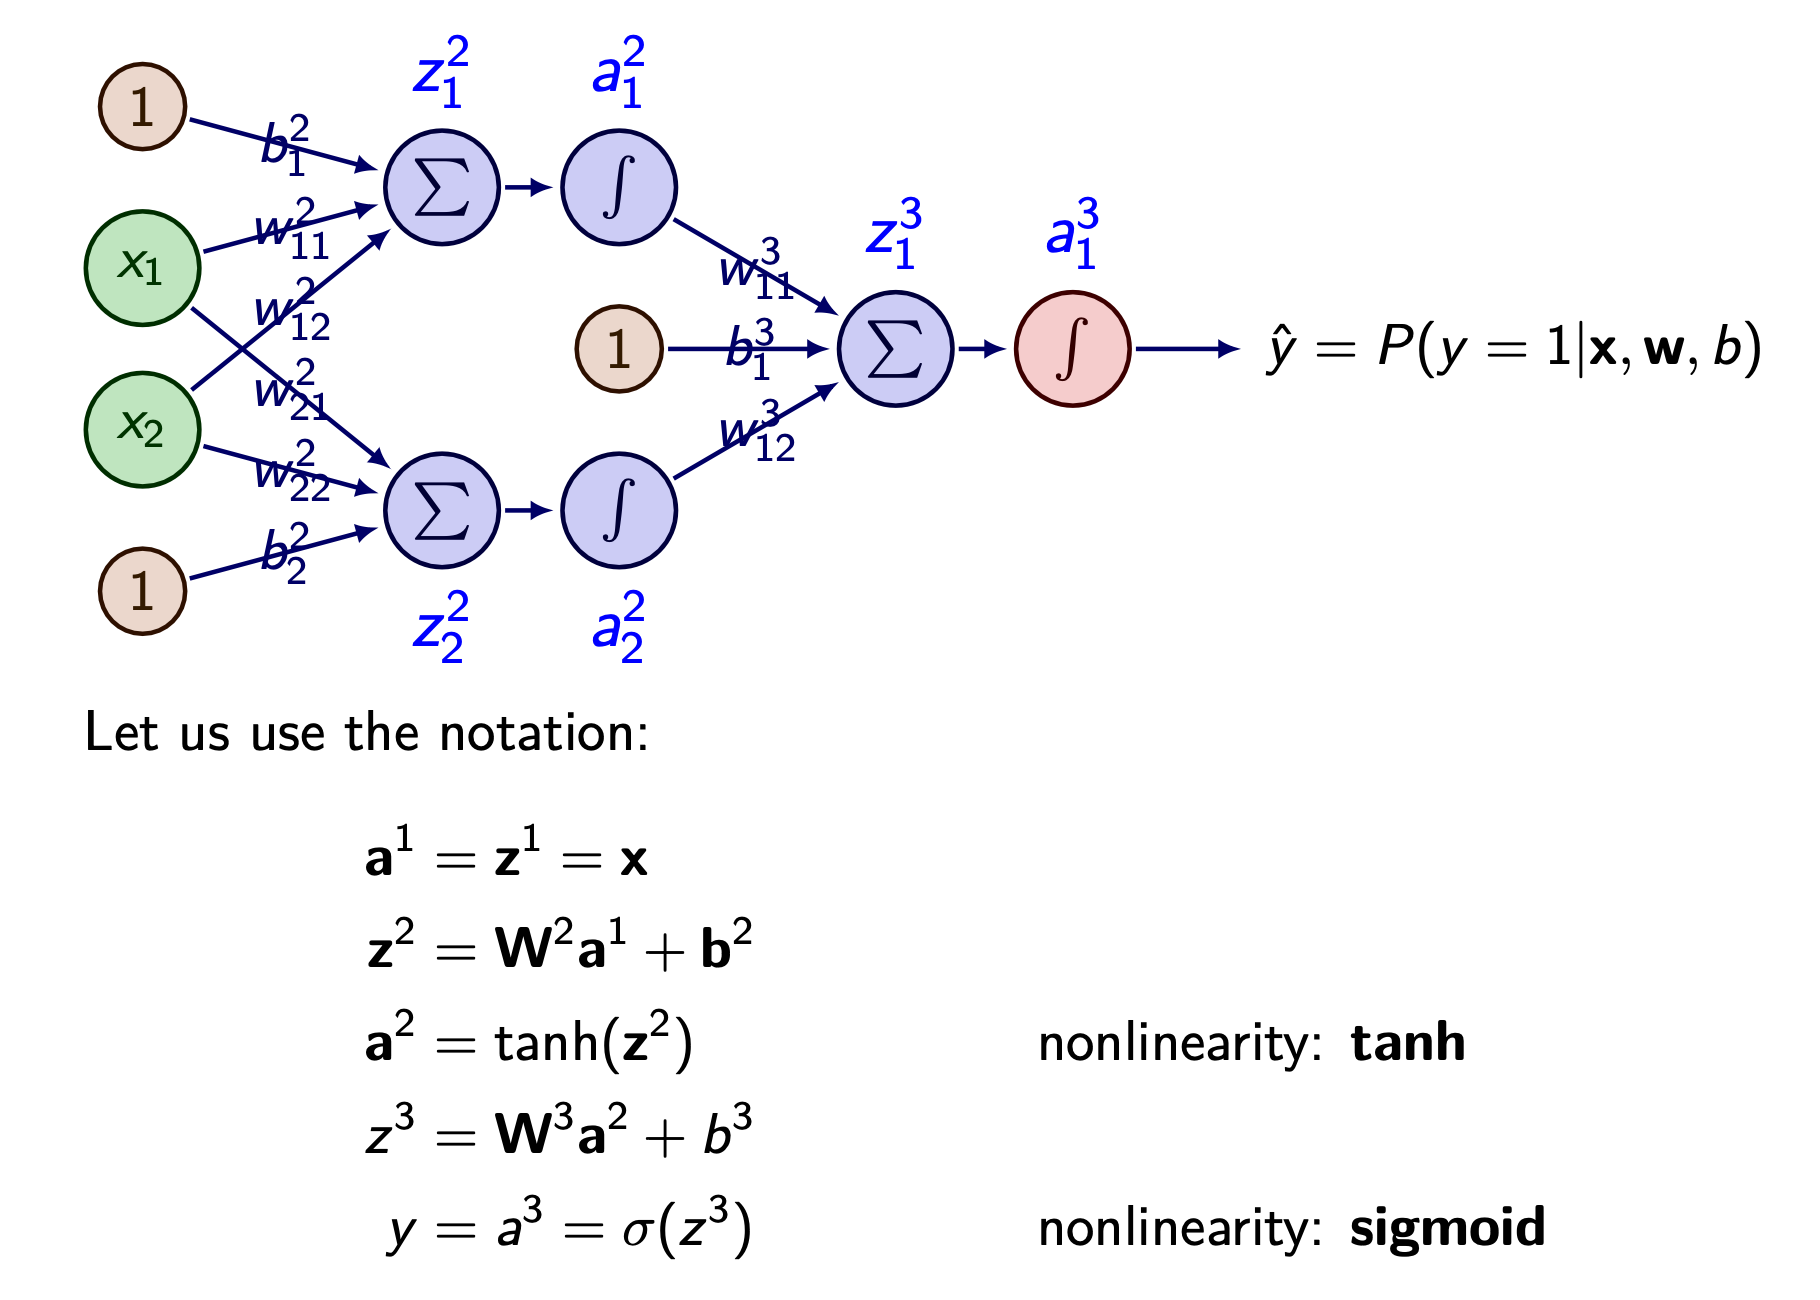

In [ ]:
# remove the following line and put your codes here
assert False

Train your MLPs. You'll need to plot the scatter plot of $(a_1^2, a_2^2)$, and the decision boundary. Discuss how the distribution of $(a_1^1, a_1^2)$ would be different that of $(x_1, x_2)$.  

In [ ]:
# put your answers here